In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
import pyspark.sql.functions as f
from pyspark.sql.functions import *
sc = spark.sparkContext

In [2]:
# Functionality for computing features
from pyspark.ml import feature
# Functionality for regression
from pyspark.ml import regression
# Funcionality for classification
from pyspark.ml import classification
# Object for creating sequences of transformations
from pyspark.ml import Pipeline

In [3]:
diabetic_df = spark.read.csv('Data/diabetic_data.csv', header = True, inferSchema = True)

In [4]:
ID_df = spark.read.csv('Data/IDs_mapping.csv', header = True, inferSchema = True)

In [5]:
diabetic_df.join(ID_df, on = 'admission_type_id').toPandas().head(5)

,admission_type_id,encounter_id,patient_nbr,race,gender,age,weight,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description
0,6,2278392,8222157,Caucasian,Female,[0-10),?,25,1,1,...,No,No,No,No,No,No,No,No,NO,Transfer from another health care facility
1,6,2278392,8222157,Caucasian,Female,[0-10),?,25,1,1,...,No,No,No,No,No,No,No,No,NO,Discharged/transferred to home with home healt...
2,6,2278392,8222157,Caucasian,Female,[0-10),?,25,1,1,...,No,No,No,No,No,No,No,No,NO,NULL
3,1,149190,55629189,Caucasian,Female,[10-20),?,1,7,3,...,Up,No,No,No,No,No,Ch,Yes,>30,Physician Referral
4,1,149190,55629189,Caucasian,Female,[10-20),?,1,7,3,...,Up,No,No,No,No,No,Ch,Yes,>30,Discharged to home


In [6]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, HiveContext
from pyspark.sql import functions as F

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
ID_df.createOrReplaceTempView("ID_Df")
diabetic_df.createOrReplaceTempView("diabetes_df")
# Read Table from hive 
ID = sqlContext.sql(' select * from ID_df')
ID.show(5)

diabetes = sqlContext.sql(' select * from diabetes_df')
diabetes.show(5)

+-----------------+-------------+
|admission_type_id|  description|
+-----------------+-------------+
|                1|    Emergency|
|                2|       Urgent|
|                3|     Elective|
|                4|      Newborn|
|                5|Not Available|
+-----------------+-------------+
only showing top 5 rows

+------------+-----------+---------------+------+-------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+------

In [7]:
df = spark.read.csv('Data/data.csv', header = True, inferSchema = True)

In [8]:
print("Shape of the Data:")
print((df.count(), len(df.columns)))

Shape of the Data:
(101766, 53)


In [9]:
df.show(1)

+------------+-----------+---------+------+------+------+-----------------+-------------------+------------------------+-------------------------+-------------------+---------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|     race|gender|   age|weight|admission_type_id|admission_type_name|discharge_disposition_id|dischage_disposition_name|admission_source_id|admission_source_name|time_in_hospital|payer_code|   medical_specialty|num_lab_procedu

In [10]:
# Check for NAN
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,admission_type_name,discharge_disposition_id,dischage_disposition_name,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Check for NULL
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).toPandas()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,admission_type_name,discharge_disposition_id,dischage_disposition_name,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Check for ?


In [28]:
# Checking for missing, max, std for numerical variables
c = ['num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient',\
     'diag_1', 'diag_2', 'diag_3']
df.select(['num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient',\
     'diag_1', 'diag_2', 'diag_3']).describe().toPandas()

,summary,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3
0,count,101766,101766,101766,101766,101766,101766,101766,101766
1,mean,1.339730361810428,16.021844230882614,0.36935715268360747,0.19783621248747127,0.635565906098304,493.5830703296686,438.6748831822862,418.1792854069298
2,stddev,1.7058069791211599,8.12756620916729,1.2672650965326782,0.9304722684224631,1.2628632900973253,206.71532043694617,178.90163753828625,177.32397864613532
3,min,0,1,0,0,0,10,11,11
4,max,6,81,42,76,21,V71,V86,V86


In [27]:
# Frequency Table for Categorical Variables
freq_table = df.select(col("readmitted").cast("string")).groupBy("readmitted").count().toPandas()
freq_table

,readmitted,count
0,>30,35545
1,NO,54864
2,<30,11357


In [14]:
# Importing plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

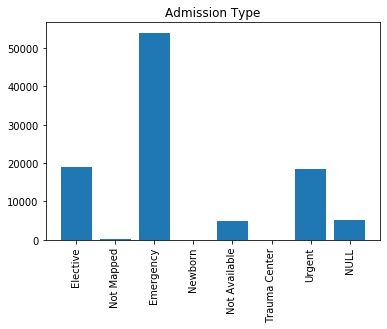

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Show histogram of the 'admission_type_name' column
d = df.groupBy("admission_type_name").count().toPandas()


height = d['count']
bars = d['admission_type_name']
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)

# Create names on the x-axis
plt.xticks(y_pos, bars, rotation = 90)

# Adding Title
plt.title('Admission Type')
 
# Show graphic
plt.show()



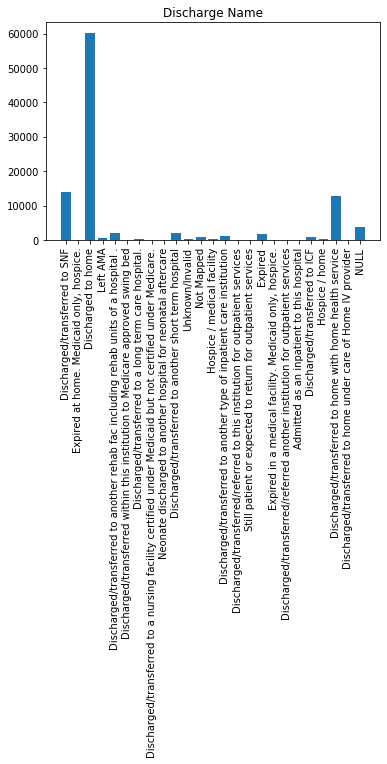

In [56]:
# Show histogram of the 'dischage_disposition_name' column
d = df.groupBy("dischage_disposition_name").count().toPandas()


height = d['count']
bars = d['dischage_disposition_name']
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)

# Create names on the x-axis
plt.xticks(y_pos, bars, rotation = 90)

# Adding Title
plt.title('Discharge Name')
 
# Show graphic
plt.show()




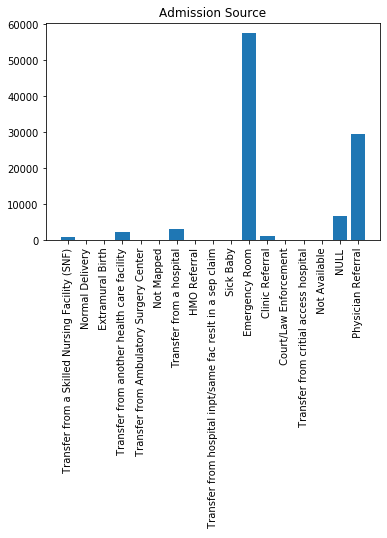

In [57]:
# Show histogram of the 'admission_source_name' column
d = df.groupBy("admission_source_name").count().toPandas()


height = d['count']
bars = d['admission_source_name']
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)

# Create names on the x-axis
plt.xticks(y_pos, bars, rotation = 90)

# Adding Title
plt.title('Admission Source')
 
# Show graphic
plt.show()



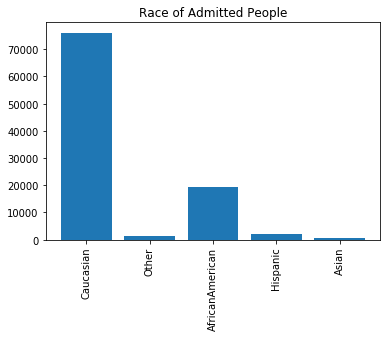

In [60]:
# Number of Females and Male Patients
d = df.groupBy('race').count().toPandas()

height = d['count'][:-1]
values = d['race'][:-1]

# Create bars
plt.bar(values, height)

# Create names on the x-axis
plt.xticks(rotation = 90)

# Adding Title
plt.title('Race of Admitted People')
 
# Show graphic
plt.show()


DataFrame[gender: string]